In [106]:
# LSTM KULLANILARAK HAVAYOLU YOLCUSU (ZAMAN SERİLERİ) TAHMİNİ
 
# Bu proje için Havayolu Yolcu veri setini kullanacağız. 
# Bu veri seti, 1949'dan 1960'a kadar ABD havayolu yolcularının aylık toplamlarını sağlar. 
# Veri setini aşağıdaki Kaggle bağlantısından indirebilirsiniz: 
# https://www.kaggle.com/chirag19/air-passengers

# Bu proje için LSTM derin öğrenme modelini kullanacağız. 
# Uzun Kısa Süreli Bellek ağı veya LSTM ağı, zaman içinde Geriye Yayılım kullanılarak eğitilen ve yok olan gradyan sorununun üstesinden gelen, tekrarlayan bir sinir ağıdır. 
# LSTM, makine öğrenimindeki zor dizi problemlerini çözmek ve en son teknolojiye sahip sonuçları elde etmek için kullanılabilecek büyük tekrarlayan ağlar oluşturmak için kullanılabilir. 
# LSTM ağlarında nöronlar yerine katmanlar aracılığıyla bağlanan bellek blokları bulunur.

# Projenin amacı:
# Son iki aydaki yolcu sayısına (binlik olarak) bakıldığında gelecek ayki yolcu sayısı ne kadardır? 
# Bu sorunu çözmek için bir LSTM modeli oluşturacağız ve bu modeli veri setimizin ilk 100 ayına ait train verilerimizle eğiteceğiz. 
# LSTM model eğitimi bittikten ve zaman serisi tren verilerindeki örüntüyü öğrendikten sonra yukarıdaki soru sorusunu soracağız ve cevabını alacağız.

In [107]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [108]:
data = pd.read_csv("AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [109]:
data.rename(columns={"#Passengers": "Passengers"},inplace=True)
data["Passengers"]

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: Passengers, Length: 144, dtype: int64

In [110]:

data = data["Passengers"]

In [111]:
type(data)

pandas.core.series.Series

In [112]:
data.head()

0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: int64

In [113]:
# Verilerim Seri, ancak MinMaxScaler() ve diğer yöntemlerimin çalışması için 2D diziye ihtiyacım var. 
# Bu yüzden numpy dizisine geçeceğim ve onu yeniden şekillendireceğim.

In [114]:
data = np.array(data).reshape(-1,1)

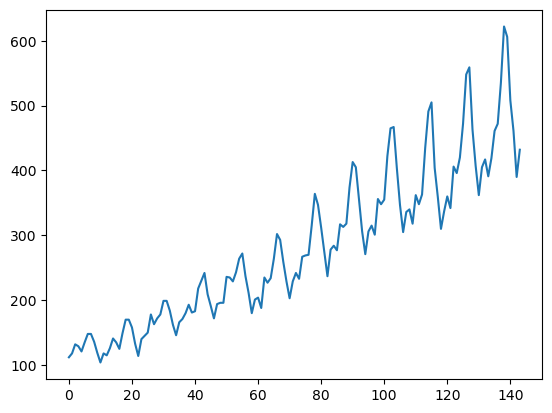

In [115]:
plt.plot(data)
plt.show()

In [116]:
# scaling..

scaler = MinMaxScaler()

data = scaler.fit_transform(data)

In [117]:
#data

In [118]:
len(data)

144

In [119]:
# 144 adet verimiz bulunuyor..

train_data = data[0:100,:]

test_data = data[100:,:]

train_data

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [120]:

# Zaman Serisi Verisini Hazırlamak:

# LSTM gibi tekrarlayan sinir ağları (RNN) geçmişteki verilere dayanarak gelecekteki değerleri tahmin etmek için tasarlanmıştır.
# Bu nedenle, modelin geçmişteki birkaç adımı (time steps) kullanarak bir sonraki adımı tahmin etmesi gerekiyor.

# Girdi ve Çıktı Setlerini Oluşturmak:
# Girdi seti (dataX), modelin gelecekteki tahminleri yaparken kullanacağı geçmiş zaman adımlarını içerir.
# Çıktı seti (dataY), tahmin edilmesi gereken değerleri içerir.

def get_data(data, steps):      
    dataX = []
    dataY = []
    for i in range(len(data)-steps-1):
        a = data[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(data[i+steps, 0])
    return np.array(dataX), np.array(dataY)

In [121]:
steps = 2

In [122]:

x_train, y_train = get_data(train_data, steps)
x_test, y_test = get_data(test_data, steps)

In [140]:
x_train.shape

(97, 1, 2)

In [124]:

# LSTM (Long Short-Term Memory) modelleri, girdi verilerini belirli bir üç boyutlu formatta alır.

# LSTM modelleri, giriş verilerini şu formatta bekler: (örnek sayısı, zaman adımı sayısı, özellik sayısı).
# Bu durumda:
# Örnek sayısı (x_train.shape[0]): Eğitim setindeki toplam örnek sayısını belirtir. 
# Bu, girdi dizisinde kaç tane zaman dilimi olduğunu ifade eder.

# Zaman adımı sayısı (1): Her bir örnekte (zaman diliminde) sadece bir adım kullanıldığı için bu değer 1’dir. 
# Yani model, bir önceki adımın (t-1) verisini kullanarak mevcut adımı (t) tahmin edecektir.

# Özellik sayısı (x_train.shape[1]): Girdi verisinin her zaman adımında kaç özellik olduğunu belirtir. 
# Örneğin, bir zaman diliminde yalnızca yolcu sayısı gibi bir özellik bulunuyorsa bu değer 1 olacaktır. 
# Ancak bu durumda, iki adım kullanıldığı için özellik sayısı 2'dir.


x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [128]:

model = Sequential()

model.add(LSTM(128, input_shape = (1, steps))) # ilk gizli katman
model.add(Dense(64))  # 2. gizli katman, 64 nörondan oluşuyor (64 memort block)
model.add(Dense(1))   # çıkış katmanı

model.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [130]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,393 (294.50 KB)

 Trainable params: 75,393 (294.50 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
model.fit(x_train, y_train, epochs=25, batch_size=1)

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - loss: 0.0302
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.0034
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.0028
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 0.0037
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.0036
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.0036
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 0.0032 
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.0032
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.0022
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.0027
Epoch 11/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.0026 
Epoch 12/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.0027 
Epoch 13/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.0024
Epoch 14/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 0.0033
Epoch 15/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step -

In [134]:
pred = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [136]:

# Modelimiz bize ölçekli tahminler verdiği için tahmin sonuçlarını yeniden ölçeklendirmeliyiz.

pred = scaler.inverse_transform(pred)
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)


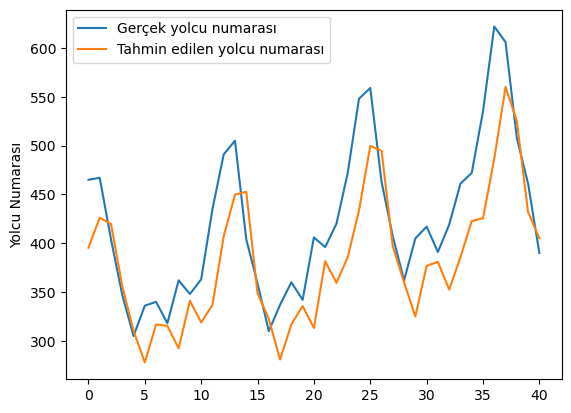

In [138]:
plt.plot(y_test, label = "Gerçek yolcu numarası")
plt.plot(pred, label = "Tahmin edilen yolcu numarası")
plt.ylabel("Aylar")
plt.ylabel("Yolcu Numarası")
plt.legend()
plt.show()